# Assignment 3: Part 2 - Classification
- Group Number: A-129
- Name: Uzair Mohiuddin
- Student Number: 8737165

## Introduction
This notebook is used to use decision trees to analyze a dataset. We will perform all the major tasks involved in a linear regression including:
1. Cleaning data
2. Numerical feature binning
3. EDA and Outlier Detection
4. Predictive Analysis: Decision Trees
5. Feature Engineering
6. Empirical Study
7. Result Analysis

## Dataset Description: Drugs A, B, C, X, Y for Decision Trees
- **Dataset**: Drugs A, B, C, X, Y for Decision Trees
- **Author**: Pablo M Gomez
- **Source**: [Kaggle](https://www.kaggle.com/datasets/pablomgomez21/drugs-a-b-c-x-y-for-decision-trees)
- **Purpose**: The dataset has medical information of patients who suffered from the same illness and tracked the effect of 5 drugs and which they responded to. The model is intended to help determine which drug to administer in the future based on age, sex, blood pressure, and cholesterol for a patient with the illness
- **Shape**: 200 rows x 6 columns
- **Features of Dataset**:
  | Feature | Categorical/Numerical | Description |
  | ------- | --------------------- | ----------- |
  | Age     | Numerical (int64)     | Age |
  | Sex     | Categorical (object)  | F/M |
  | BP     | Categorical (object) | HIGH/NORMAL/LOW |
  | Cholesterol | Categorical (object)  | HIGH/NORMAL/LOW |
  | Na_to_K  | Numerical (float64) | Sodium to Potassium conversion |
  | Drug  | Categorical (object) | Drug that worked with that patient (drugA/drugB/drugC/drugX/drugY) |
  

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from IPython.display import display, Markdown

In [2]:
# URL for dataset
drug_dataset_url = "https://raw.githubusercontent.com/uzaaaiiir/jupyter/refs/heads/main/intro_ds_assignments/assignment3/drug200.csv"

# Load dataset
df = pd.read_csv(drug_dataset_url)

In [3]:
# Shape of dataset
df.shape

(200, 6)

In [4]:
# Get list of features and descriptions
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [5]:
'''
describe() to retrieve numerical attributes.

Numerical attributes: Age, Na_to_K
'''
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [6]:
'''
Categorical attributes of the dataset.

Categorical attributes are: Sex, BP, Cholesterol, Drug
'''
df.describe(include="object")

,Sex,BP,Cholesterol,Drug
count,200,200,200,200
unique,2,3,2,5
top,M,HIGH,HIGH,drugY
freq,104,77,103,91


In [7]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


# Classification Empirical Study

## 1. Clean Data
This step involves performing validity checks and imputation of missing data. 

In [8]:
'''
Presence Check
- No attributes are missing values. 
'''
df_copy = df.copy(deep=True)

attributes = ['Age', "Sex", 'BP', 'Cholesterol', 'Na_to_K', 'Drug']
test = 'Drug'

missing = df_copy[df_copy[test].isna()]
missing

,Age,Sex,BP,Cholesterol,Na_to_K,Drug


In [9]:
'''
Range Check:
- There are 3 values out of range for Na_to_K. The normal range is until 35.
'''
attributes = ['age', 'bmi', 'children', 'charges']

valid_ranges = {
    "Age": (0, 120),
    'Na_to_K': (0, 30)
}

test = "Na_to_K"
out_of_range = df_copy[(df_copy[test] < 0) | (df_copy[test] > 35)]
out_of_range

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
96,58,F,LOW,HIGH,38.247,drugY
98,20,M,HIGH,NORMAL,35.639,drugY
184,18,F,HIGH,HIGH,37.188,drugY


In [10]:
'''
Lookup check
- No attributes have invalid values
'''
attributes = ['sex', 'smoker', 'region']

valid_categories = {
    "BP": {"LOW", "NORMAL", "HIGH"},
    "Cholesterol": {"LOW", "NORMAL", "HIGH"},
    "Drug": {"drugA", "drugB", "drugC", "drugX", "drugY"}
}

# Check for invalid category values
for col, valid_values in valid_categories.items():
    invalid_values = df_copy[~df_copy[col].isin(valid_values)]
    if not invalid_values.empty:
        print(f"Warning: {col} contains invalid values")
        print(invalid_values[col].unique())

## 2. Categorical Feature Encoding
Performing one-hot encoding to transform categorical features into numerical features. 

In [11]:
'''
Binning
- We can perform binning on the Na_to_K conversion.
'''
bins = [0, 10, 20, np.inf]
labels = ['LOW', 'NORMAL', 'HIGH']
df_copy["Na_to_K_Binned"] = pd.cut(df_copy["Na_to_K"], bins=bins, labels=labels, right=False)

df_copy

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Na_to_K_Binned
0,23,F,HIGH,HIGH,25.355,drugY,HIGH
1,47,M,LOW,HIGH,13.093,drugC,NORMAL
2,47,M,LOW,HIGH,10.114,drugC,NORMAL
3,28,F,NORMAL,HIGH,7.798,drugX,LOW
4,61,F,LOW,HIGH,18.043,drugY,NORMAL
...,...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC,NORMAL
196,16,M,LOW,HIGH,12.006,drugC,NORMAL
197,52,M,NORMAL,HIGH,9.894,drugX,LOW
198,23,M,NORMAL,NORMAL,14.020,drugX,NORMAL


## 3. EDA and Outlier Detection
1. Perform outlier detection using Local Outlier Factor (LOF).
2. Use EDA to visualize data and find which feature LOF should be used on. If there are no features with outliers, then introduce some outliers for at least one feature to use LOF to detect them.
3. Decide what to do with outliers (remove them or impute them).

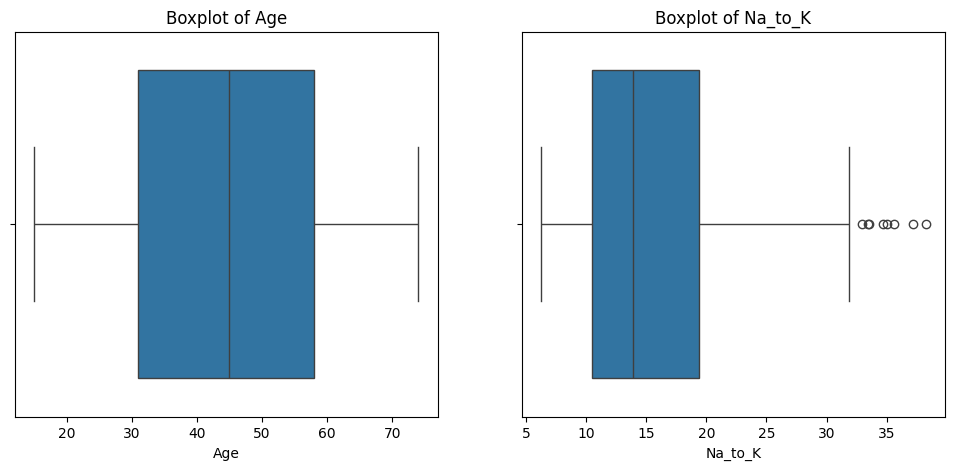

In [12]:
'''
EDA to visualize data and outliers.
- Na_to_K has several outliers.
'''
plt.figure(figsize=(12, 5))

# Boxplot for Age
plt.subplot(1, 2, 1)
sns.boxplot(x=df["Age"])
plt.title("Boxplot of Age")

# Boxplot for Na_to_K
plt.subplot(1, 2, 2)
sns.boxplot(x=df["Na_to_K"])
plt.title("Boxplot of Na_to_K")

plt.show()

In [13]:
'''
Applying Local Outlier Factor to detect outliers.
- 3 outliers
'''

numerical_attributes = ['Age', 'Na_to_K']

lof = LocalOutlierFactor(n_neighbors=40)
outlier_labels = lof.fit_predict(df_copy[numerical_attributes])

df_copy['lof'] = (outlier_labels == -1).astype(int)
print(f"Number of Outliers Detected: {df_copy['lof'].sum()}")


df_copy[df_copy['lof'] == 1]

Number of Outliers Detected: 3


,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Na_to_K_Binned,lof
96,58,F,LOW,HIGH,38.247,drugY,HIGH,1
98,20,M,HIGH,NORMAL,35.639,drugY,HIGH,1
184,18,F,HIGH,HIGH,37.188,drugY,HIGH,1


In [14]:
'''
We identified 3 outliers. Let's remove them.
'''
df_cleaned = df_copy[df_copy['lof'] == 0].drop(columns=['lof'])

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 0 to 199
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             197 non-null    int64   
 1   Sex             197 non-null    object  
 2   BP              197 non-null    object  
 3   Cholesterol     197 non-null    object  
 4   Na_to_K         197 non-null    float64 
 5   Drug            197 non-null    object  
 6   Na_to_K_Binned  197 non-null    category
dtypes: category(1), float64(1), int64(1), object(4)
memory usage: 11.1+ KB


## 4. Predictive Analysis (Classification)
Explore Decision Trees using scikit-learn.

In [15]:
'''
Decision Trees
'''
df_copy.drop(columns=["lof"], inplace=True, errors="ignore")
df_encoded = df_copy.copy(deep=True)

# Apply Label Encoding for Binary Categorical Columns
le_sex = LabelEncoder()
df_encoded["Sex"] = le_sex.fit_transform(df_encoded["Sex"]).astype(int)

le_na_to_k = LabelEncoder()
df_encoded["Na_to_K_Binned"] = le_na_to_k.fit_transform(df_encoded["Na_to_K_Binned"]).astype(int)  # F → 0, M → 1

le_drug = LabelEncoder()
df_encoded["Drug"] = le_drug.fit_transform(df_encoded["Drug"])  # A → 0, B → 1, etc.

# Apply One-Hot Encoding for Multi-Class Categorical Columns
df_encoded = pd.get_dummies(df_encoded, columns=["BP", "Cholesterol"], drop_first=True).astype(int)

X = df_encoded.drop(columns=["Drug"])
y = df_encoded['Drug']

# Split data into Training (70%) and Testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_encoded.head()

,Age,Sex,Na_to_K,Drug,Na_to_K_Binned,BP_LOW,BP_NORMAL,Cholesterol_NORMAL
0,23,0,25,4,0,0,0,0
1,47,1,13,2,2,1,0,0
2,47,1,10,2,2,1,0,0
3,28,0,7,3,1,0,1,0
4,61,0,18,4,2,1,0,0


In [16]:
def clean_data(df):
    df_cleaner = df_copy.copy(deep=True)
    
    # Apply Label Encoding for Binary Categorical Columns
    le_sex = LabelEncoder()
    df_cleaner["Sex"] = le_sex.fit_transform(df_cleaner["Sex"]).astype(int)
    
    le_na_to_k = LabelEncoder()
    df_cleaner["Na_to_K_Binned"] = le_na_to_k.fit_transform(df_cleaner["Na_to_K_Binned"]).astype(int)  # F → 0, M → 1
    
    le_drug = LabelEncoder()
    df_cleaner["Drug"] = le_drug.fit_transform(df_cleaner["Drug"])  # A → 0, B → 1, etc.
    
    # Apply One-Hot Encoding for Multi-Class Categorical Columns
    df_cleaner = pd.get_dummies(df_cleaner, columns=["BP", "Cholesterol"], drop_first=True).astype(int)

    return df_cleaner

Baseline Decision Tree Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        15

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



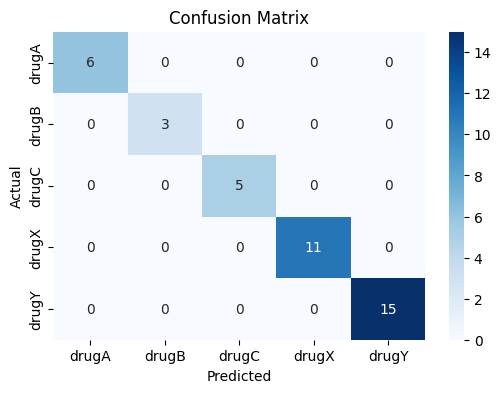

In [17]:
# Initialize Decision Tree with baseline settings
dt_baseline = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=2, random_state=42)

# Train the model
dt_baseline.fit(X_train, y_train)

# Make predictions
y_pred = dt_baseline.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Decision Tree Accuracy: {accuracy}")

# Show Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display Confusion Matrix with Correct Class Labels
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=le_drug.classes_, 
    yticklabels=le_drug.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 5. Feature Engineering
Program a feature aggregator to create 2 additional features. This involves thinking of interesting ways to combine features based on the dataset and what could make sense. 

In [18]:
'''
Feature aggregation:
- bmi * age might tell us if older individuals with higher bmi have higher costs.
- children per age
'''
df_aggregate = df_encoded.copy(deep=True)
df_aggregate["Age^2"] = df_aggregate["Age"] ** 2

## 6. Empirical Study
1. Split data into 3 subsets for train, validation, and test sets.
2. Decide on evaluation metrics (MSE, LMSE, R2).
3. Use linear regression with baseline settings, without outlier removal and without feature aggregation. Evaluate on a validation set using a 4-fold cross validation.
4. Try different combinations. Find the best system.
5. Decide on the final system which is the best one according to the study. 

In [19]:
'''
Empirical Study
- Split dataset into 3 subsets.
'''
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [20]:
'''
Baseline
'''
dt_baseline = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=2, random_state=42)

# Perform 4-fold cross-validation
cv_scores = cross_val_score(dt_baseline, X_train, y_train, cv=4, scoring="accuracy")

# Print results
print(f"Baseline Decision Tree - 4-Fold Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Baseline Decision Tree - 4-Fold Cross-Validation Accuracy: 0.9917 ± 0.0144


In [21]:
# Outlier removal
df_cleaned_encoded = clean_data(df_cleaned)

X_train_no_outliers = df_cleaned_encoded.drop(columns=["Drug"])
y_train_no_outliers = df_cleaned_encoded['Drug']
dt_no_outliers = DecisionTreeClassifier(random_state=42)
cv_scores_no_outliers = cross_val_score(dt_no_outliers, X_train_no_outliers, y_train_no_outliers, cv=4, scoring="accuracy")
print(f"Decision Tree with Outlier Removal - 4-Fold CV Accuracy: {cv_scores_no_outliers.mean():.4f} ± {cv_scores_no_outliers.std():.4f}")

Decision Tree with Outlier Removal - 4-Fold CV Accuracy: 0.9900 ± 0.0173


In [22]:
# Feature Aggregation
# Outlier removal
df_aggregate_encoded = clean_data(df_aggregate)

X_train_aggregate = df_aggregate_encoded.drop(columns=["Drug"])
y_train_aggregate = df_aggregate_encoded['Drug']
dt_aggregate = DecisionTreeClassifier(random_state=42)
cv_scores_aggregate = cross_val_score(dt_aggregate, X_train_aggregate, y_train_aggregate, cv=4, scoring="accuracy")
print(f"Decision Tree with Aggregate Removal - 4-Fold CV Accuracy: {cv_scores_aggregate.mean():.4f} ± {cv_scores_aggregate.std():.4f}")

Decision Tree with Aggregate Removal - 4-Fold CV Accuracy: 0.9900 ± 0.0173


Final Model Accuracy on Test Set: 1.0000


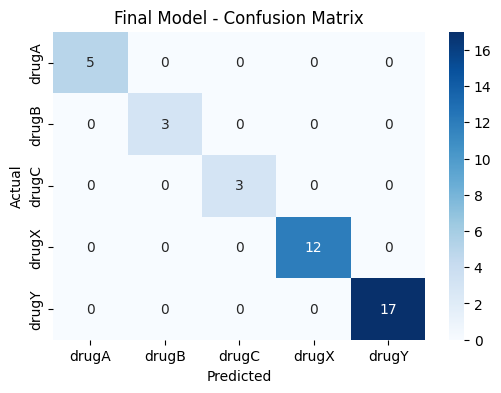

In [23]:
'''
The baseline is the best system. We can use it to perform the final evaluation.
'''
# Train Final Model on Training Set
final_model = DecisionTreeClassifier(random_state=42)
final_model.fit(X_train, y_train)

# Test Set Predictions
y_test_pred = final_model.predict(X_test)

# Evaluate on Test Set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Final Model Accuracy on Test Set: {test_accuracy:.4f}")

# Show Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d", cmap="Blues", xticklabels=le_drug.classes_, yticklabels=le_drug.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Model - Confusion Matrix")
plt.show()

## 7. Result Analysis
We conducted the empirical study to evaluate the different settings for the Decision Tree Classifier. Based on the test using 4-fold cross validation, we found that the baseline decision tree was best with a 0.9917 accuracy. Removing outliers or performing aggregation did not significantly affect accuracy. 

# Conclusion
The overall conclusion was that the prediction accuracy was best with the baseline, and removing outliers to feature engineering didn't make an impact. This indicated that the decision tree model handled data effectively in making predictions without additional preprocessing. 

# References
- Week 7 Predictive Analysis Decision Trees Lecture
- Week 8 Predictive Analysis Feature Engineering
- ChatGTP Prompts
  - How do we perform a decision tree classification on a dataset, and how do we format the data?